In [1]:
from utils import UNetResNet50, check_band_coverage, pansharpen_to_10m_and_save, predict_full_tile, save_prediction_geotiff, compute_metrics
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import rasterio

### Pansharpen Test Data

In [19]:
check_band_coverage("data/S2A_MSIL1C_20210508T092031_N0500_R093_T34SEH_20230303T013318.SAFE/GRANULE/L1C_T34SEH_A030692_20210508T092338/IMG_DATA")


 L1C_T34SEH_A030692_20210508T092338

Band   Resolution Shape           Valid Pixels (%)  
------------------------------------------------------------
B01    60.0       (1830, 1830)    100.00            
B02    10.0       (10980, 10980)  100.00            
B03    10.0       (10980, 10980)  100.00            
B04    10.0       (10980, 10980)  100.00            
B05    20.0       (5490, 5490)    100.00            
B06    20.0       (5490, 5490)    100.00            
B07    20.0       (5490, 5490)    100.00            
B08    10.0       (10980, 10980)  100.00            
B09    60.0       (1830, 1830)    100.00            
B10    60.0       (1830, 1830)    100.00            
B11    20.0       (5490, 5490)    100.00            
B12    20.0       (5490, 5490)    100.00            
B8A    20.0       (5490, 5490)    100.00            


In [20]:
pansharpen_to_10m_and_save("data/S2A_MSIL1C_20210508T092031_N0500_R093_T34SEH_20230303T013318.SAFE/GRANULE/L1C_T34SEH_A030692_20210508T092338/IMG_DATA", output_tiff="data/T34SEH_pansharpened.tif")

['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
1 B01
2 B02
3 B03
4 B04
5 B05
6 B06
7 B07
8 B08
9 B8A
10 B09
11 B10
12 B11
13 B12

Saved pansharpened image to: data/T34SEH_pansharpened.tif


### Inference

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = UNetResNet50(num_classes=8).to(device)
model.load_state_dict(torch.load("best_model_lr_0.0001.pt", map_location=device, weights_only=True))
pred_mask = predict_full_tile(model, "data/T34SEH_pansharpened.tif", device, patch_size=128, stride=64, num_classes=8, output_path="predicted_mask.npy")

/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 170/170 [04:33<00:00,  1.61s/it]


Prediction saved to predicted_mask.npy


In [4]:
save_prediction_geotiff(pred_mask, "data/T34SEH_pansharpened.tif", "pred_mask.tif")

GeoTIFF saved to: pred_mask.tif


In [5]:
id2idx = {10: 0, 20: 1, 30: 2, 40: 3, 50: 4, 60: 5, 80: 6, 90: 7}
idx2id = {v: k for k, v in id2idx.items()}

# remapping
remapped_mask = np.vectorize(idx2id.get)(pred_mask).astype(np.uint8)
np.unique(pred_mask), np.unique(remapped_mask)

(array([0, 1, 2, 3, 4, 5, 6], dtype=uint8),
 array([10, 20, 30, 40, 50, 60, 80], dtype=uint8))

### Evaluation

In [12]:
def load_reference_mask(path):
    with rasterio.open(path) as src:
        mask = src.read(1)
    return mask


true_mask = load_reference_mask("data/GBDA24_ex2_34SEH_ref_data.tif")
class_ids = [10, 20, 30, 40, 50, 60, 80, 90]
metrics = compute_metrics(remapped_mask, true_mask, class_ids)
print("Pixel Accuracy:", metrics["pixel_accuracy"])
print("Per-Class IoU:", metrics["iou_per_class"])
print("Mean IoU:", metrics["mean_iou"])


Pixel Accuracy: 0.7508253886707643
Per-Class IoU: {10: np.float64(0.7258283394437622), 20: np.float64(0.04968237770667938), 30: np.float64(0.18715757604524064), 40: np.float64(0.2584323683147882), 50: np.float64(0.1721664531071201), 60: np.float64(0.04611749934373815), 80: np.float64(0.956728629252614), 90: np.float64(0.0)}
Mean IoU: 0.29951415540174287


In [14]:
save_prediction_geotiff(remapped_mask, "data/T34SEH_pansharpened.tif", "pred_mask.tif")

GeoTIFF saved to: pred_mask.tif


In [15]:
def copy_colormap(ref_path, pred_path, output_path):
    # load colormap from ground truth
    with rasterio.open(ref_path) as ref_src:
        cmap = ref_src.colormap(1)
        profile = ref_src.profile

    with rasterio.open(pred_path) as pred_src:
        pred_data = pred_src.read(1)
        pred_profile = pred_src.profile

    # update the profile to include the colormap
    pred_profile.update({
        'count': 1,
        'dtype': pred_data.dtype,
        'driver': 'GTiff',
        'compress': 'lzw'
    })

    with rasterio.open(output_path, 'w', **pred_profile) as dst:
        dst.write(pred_data, 1)
        dst.write_colormap(1, cmap)

    print(f"Colormap copied from {ref_path} to {output_path}")

copy_colormap("data/GBDA24_ex2_34SEH_ref_data.tif", "pred_mask.tif", "pred_mask_colored.tif")

Colormap copied from data/GBDA24_ex2_34SEH_ref_data.tif to pred_mask_colored.tif


In [20]:
metrics = compute_metrics(remapped_mask, true_mask, class_ids, ignore_index=None)
metrics

{'pixel_accuracy': np.float64(0.7508253886707643),
 'iou_per_class': {10: np.float64(0.7258283394437622),
  20: np.float64(0.04968237770667938),
  30: np.float64(0.18715757604524064),
  40: np.float64(0.2584323683147882),
  50: np.float64(0.1721664531071201),
  60: np.float64(0.04611749934373815),
  80: np.float64(0.956728629252614),
  90: np.float64(0.0)},
 'mean_iou': np.float64(0.29951415540174287),
 'freq_weighted_iou': np.float64(0.6250807240592036),
 'confusion_matrix': array([[53598245,   262243,  1155982,  2525199,   146986,     1511,
           178316,        0],
        [ 4380406,   346845,  1244049,   326266,    11799,      316,
            29351,        0],
        [ 9133243,   354125,  4195447,  5089331,   210397,    15739,
           101252,        0],
        [ 1192893,    11077,   311418,  3686362,    43183,      556,
            16440,        0],
        [  559663,     8980,   247562,   356286,   376887,    13069,
            76285,        0],
        [  114166,     37

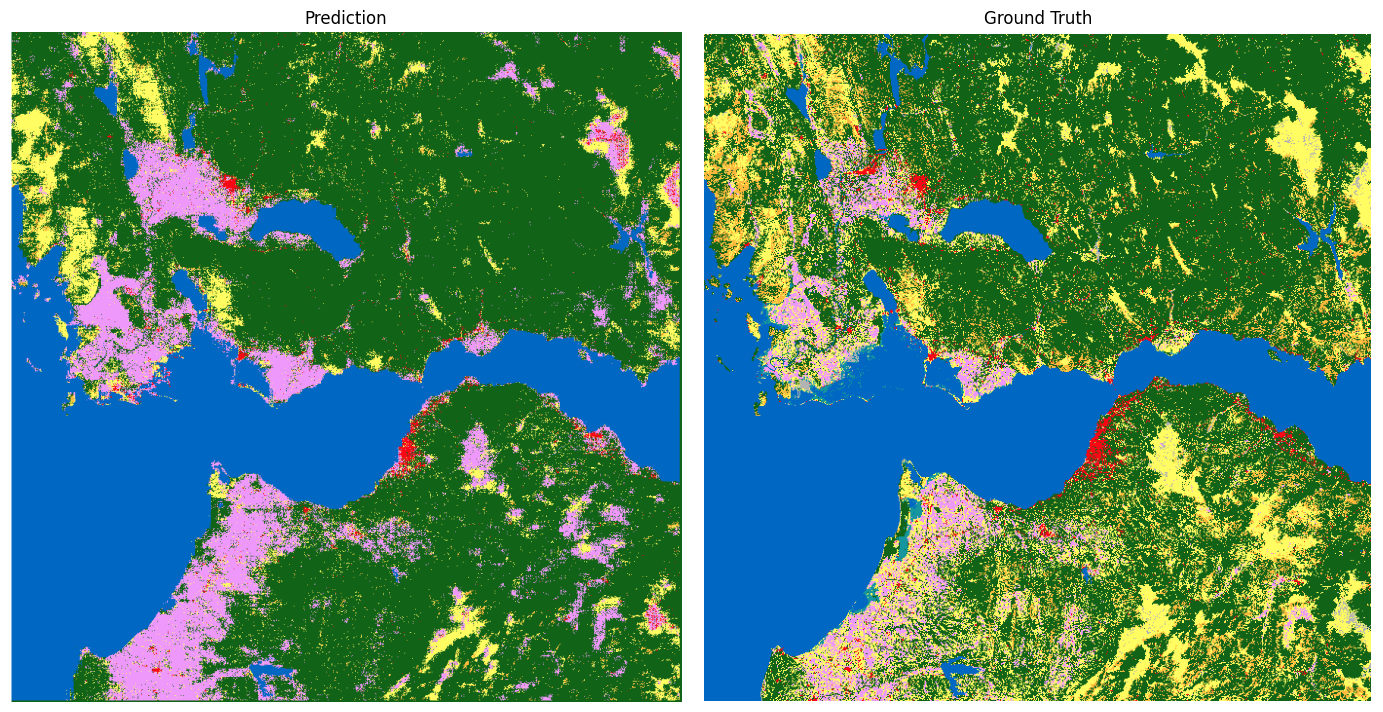

In [9]:
png1 = "/home/alex/Downloads/pred_fin.png"
png2 = "/home/alex/Downloads/ref_fin.png"

img1 = mpimg.imread(png1)
img2 = mpimg.imread(png2)

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].imshow(img1)
axs[0].set_title(png1.split('/')[-1])
axs[0].axis('off')
axs[0].set_title("Prediction")

axs[1].imshow(img2)
axs[1].set_title(png2.split('/')[-1])
axs[1].axis('off')
axs[1].set_title("Ground Truth")

plt.tight_layout()
plt.savefig("pred_gt.svg", dpi=300)
plt.savefig("pred_gt.png", dpi=300)
plt.show()
